In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import joblib
from xgboost import XGBRegressor
import datetime
from sklearn.preprocessing import MinMaxScaler


# Load the datasets
train = pd.read_csv("train.csv")
store = pd.read_csv("store.csv")

# Merge datasets
data = pd.merge(train, store, on="Store", how="left")
print(data.head())


<ipython-input-1-1de42afd8b76>:18: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train.csv")


   Store  DayOfWeek        Date    Sales  Customers  Open  Promo StateHoliday  \
0      1        5.0  2015-07-31   5263.0      555.0   1.0    1.0            0   
1      2        5.0  2015-07-31   6064.0      625.0   1.0    1.0            0   
2      3        5.0  2015-07-31   8314.0      821.0   1.0    1.0            0   
3      4        5.0  2015-07-31  13995.0     1498.0   1.0    1.0            0   
4      5        5.0  2015-07-31   4822.0      559.0   1.0    1.0            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0            1.0         c          a               1270.0   
1            1.0         a          a                570.0   
2            1.0         a          a              14130.0   
3            1.0         c          c                620.0   
4            1.0         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1       

In [2]:
print(data.isnull().sum())

#Fill missing values in `CompetitionDistance` and other columns
data['CompetitionDistance'] = data['CompetitionDistance'].fillna(data['CompetitionDistance'].median())
data['CompetitionOpenSinceMonth'] = data['CompetitionOpenSinceMonth'].fillna(0)
data['CompetitionOpenSinceYear'] = data['CompetitionOpenSinceYear'].fillna(0)
data['Promo2SinceWeek'] = data['Promo2SinceWeek'].fillna(0)
data['Promo2SinceYear'] = data['Promo2SinceYear'].fillna(0)
data['PromoInterval'] = data['PromoInterval'].fillna("None")


Store                             0
DayOfWeek                         1
Date                              1
Sales                             1
Customers                         1
Open                              1
Promo                             1
StateHoliday                      1
SchoolHoliday                     1
StoreType                         0
Assortment                        0
CompetitionDistance            1338
CompetitionOpenSinceMonth    169453
CompetitionOpenSinceYear     169453
Promo2                            0
Promo2SinceWeek              271539
Promo2SinceYear              271539
PromoInterval                271539
dtype: int64


In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Weekday'] = data['Date'].dt.weekday
data['IsWeekend'] = data['Weekday'].apply(lambda x: 1 if x >= 5 else 0)
data['MonthSegment'] = data['Day'].apply(lambda x: 0 if x <= 10 else (1 if x <= 20 else 2))


In [4]:
# Encode PromoInterval
promo_months = {'None': [], 'Jan,Apr,Jul,Oct': [1, 4, 7, 10], 'Feb,May,Aug,Nov': [2, 5, 8, 11], 'Mar,Jun,Sept,Dec': [3, 6, 9, 12]}
data['IsPromoMonth'] = data.apply(lambda x: 1 if x['Month'] in promo_months[x['PromoInterval']] else 0, axis=1)


In [5]:
categorical_columns = ['DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']  # Replace with your actual categorical columns


for col in categorical_columns:
    print(f"{col} unique values and types:")
    print(data[col].apply(type).unique())
for col in categorical_columns:
    data[col] = data[col].astype(str)
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
for col in categorical_columns:
    data[col] = encoder.fit_transform(data[col])
for col in categorical_columns:
    print(f"Encoded values for {col}:")
    print(data[col].unique())

DayOfWeek unique values and types:
[<class 'float'>]
Open unique values and types:
[<class 'float'>]
Promo unique values and types:
[<class 'float'>]
StateHoliday unique values and types:
[<class 'str'> <class 'int'> <class 'float'>]
SchoolHoliday unique values and types:
[<class 'float'>]
StoreType unique values and types:
[<class 'str'>]
Assortment unique values and types:
[<class 'str'>]
CompetitionOpenSinceMonth unique values and types:
[<class 'float'>]
CompetitionOpenSinceYear unique values and types:
[<class 'float'>]
Promo2 unique values and types:
[<class 'int'>]
Promo2SinceWeek unique values and types:
[<class 'float'>]
Promo2SinceYear unique values and types:
[<class 'float'>]
PromoInterval unique values and types:
[<class 'str'>]
Encoded values for DayOfWeek:
[4 3 2 1 0 6 5 7]
Encoded values for Open:
[1 0 2]
Encoded values for Promo:
[1 0 2]
Encoded values for StateHoliday:
[0 2 3 4 1 5]
Encoded values for SchoolHoliday:
[1 0 2]
Encoded values for StoreType:
[2 0 3 1]
Enco

In [11]:
print(data.columns)


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day', 'Weekday',
       'IsWeekend', 'MonthSegment', 'IsPromoMonth'],
      dtype='object')


In [10]:
# Check for the existence of 'Sales' column
if 'Sales' in data.columns:
    # Calculate min and max
    min_value = data['Sales'].min()
    max_value = data['Sales'].max()

    print(f"Min: {min_value}, Max: {max_value}")
else:
    print("The 'Sales' column is not in the merged dataset.")


Min: 0.0, Max: 41551.0


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_features = ['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day', 'Weekday']
data[numeric_features] = scaler.fit_transform(data[numeric_features])


In [ ]:
from sklearn.model_selection import train_test_split

X = data.drop(['Sales', 'Customers', 'Date', 'Store'], axis=1)
y = data['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
print(X_train.dtypes)



DayOfWeek                      int64
Open                           int64
Promo                          int64
StateHoliday                   int64
SchoolHoliday                  int64
StoreType                      int64
Assortment                     int64
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                  int64
Year                         float64
Month                        float64
Day                          float64
Weekday                      float64
IsWeekend                      int64
MonthSegment                   int64
IsPromoMonth                   int64
dtype: object


In [ ]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for month in months:
    X_train[f'Promo_{month}'] = X_train['PromoInterval'].apply(lambda x: 1 if month in str(x) else 0)
    X_test[f'Promo_{month}'] = X_test['PromoInterval'].apply(lambda x: 1 if month in str(x) else 0)

# Drop the original PromoInterval column
X_train = X_train.drop('PromoInterval', axis=1)
X_test = X_test.drop('PromoInterval', axis=1)


In [ ]:
print(X_train.dtypes)


DayOfWeek                      int64
Open                           int64
Promo                          int64
StateHoliday                   int64
SchoolHoliday                  int64
StoreType                      int64
Assortment                     int64
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
Year                         float64
Month                        float64
Day                          float64
Weekday                      float64
IsWeekend                      int64
MonthSegment                   int64
IsPromoMonth                   int64
Promo_Jan                      int64
Promo_Feb                      int64
Promo_Mar                      int64
Promo_Apr                      int64
Promo_May                      int64
Promo_Jun                      int64
Promo_Jul                      int64
P

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline([
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


RMSE: 1044.689181657305


In [ ]:
import joblib
import datetime

timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
joblib.dump(pipeline, f"sales_model_{timestamp}.pkl")


['sales_model_2025-01-10-17-15-02.pkl']

Create Supervised Data for LSTM

In [ ]:
# Function to transform the data into supervised learning format
def create_supervised_data(df, lag=1):
    cols = ['Sales', 'Customers', 'Promo']  # Example columns
    df_supervised = df[cols].shift(lag)  # Shift data by 'lag' days
    df_supervised['Sales'] = df['Sales']  # Target column
    df_supervised.dropna(inplace=True)  # Remove any rows with NaN after shifting
    return df_supervised

# Prepare the data with a lag of 7 days
lag = 7  # We will use the last 7 days to predict the next day's sales
supervised_data = create_supervised_data(data, lag=lag)

# Scale the data between -1 and 1 using MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(supervised_data)

# Convert back to DataFrame after scaling
scaled_data = pd.DataFrame(scaled_data, columns=supervised_data.columns)

# Check the first few rows of the scaled data
print(scaled_data.head())


      Sales  Customers  Promo
0 -0.591249  -0.796629    1.0
1 -0.587736  -0.770978    1.0
2 -0.654160  -0.699157    1.0
3 -0.496667  -0.451081    1.0
4 -0.568771  -0.795163    1.0


 Prepare the LSTM Input Format

In [ ]:
# Function to create the data in the 3D format (samples, time_steps, features)
def create_lstm_data(data, time_steps=7):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:i+time_steps, :-1].values)  # All columns except target
        y.append(data.iloc[i+time_steps, -1])  # Target column (Sales)
    return np.array(X), np.array(y)

# Prepare the dataset
X, y = create_lstm_data(scaled_data, time_steps=lag)

# Reshape X to be 3D [samples, time_steps, features]
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Check the shapes of the training and testing data
print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing data shape: X_test={X_test.shape}, y_test={y_test.shape}")


Training data shape: X_train=(201846, 7, 2), y_train=(201846,)
Testing data shape: X_test=(50462, 7, 2), y_test=(50462,)


Build the LSTM Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()

# Add LSTM layers
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))

# Output layer with one value (Sales)
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - loss: 0.5477 - val_loss: 0.6140
Epoch 2/10
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 81s 13ms/step - loss: 0.4012 - val_loss: 0.6323
Epoch 3/10
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - loss: 0.3773 - val_loss: 0.6511
Epoch 4/10
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 82s 13ms/step - loss: 0.3656 - val_loss: 0.6262
Epoch 5/10
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 80s 13ms/step - loss: 0.3562 - val_loss: 0.5598
Epoch 6/10
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 0.3494 - val_loss: 0.5942
Epoch 7/10
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 0.3374 - val_loss: 0.5924
Epoch 8/10
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 0.3300 - val_loss: 0.5526
Epoch 9/10
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - loss: 0.3226 - val_loss: 0.5450
Epoch 10/10
3154/3154 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 0.3140 - val_loss: 0.5709


In [ ]:
# Save the trained LSTM model in the new Keras format
model.save('sales_model.keras')
# Load the model from the new Keras format
model = tf.keras.models.load_model('sales_model.keras')


In [ ]:
print(model.input_shape)

(None, 7, 2)


Evaluate the Model and Make Predictions

1577/1577 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.4602
Mean Squared Error on Test Set: 0.5708889961242676
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


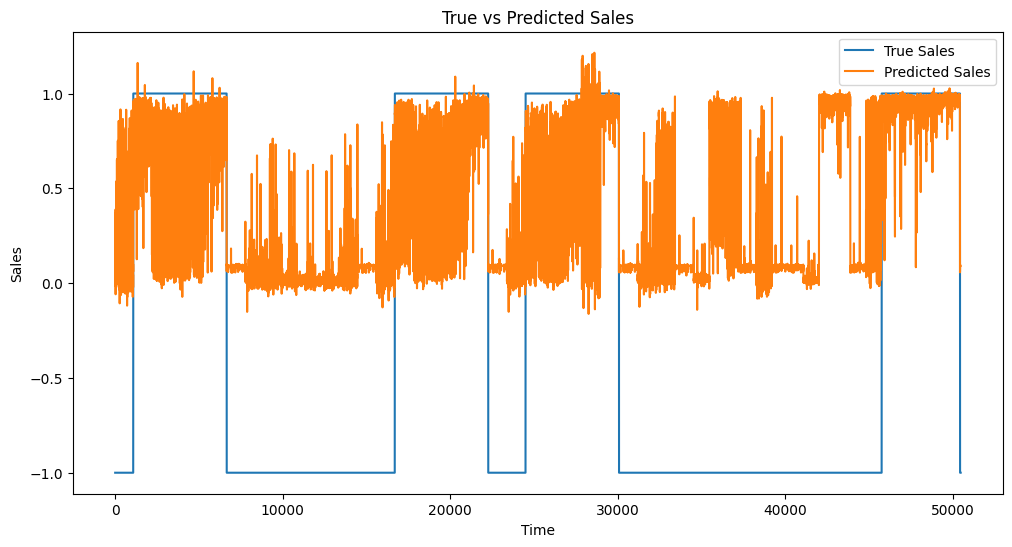

In [ ]:
# Evaluate the model on the test data
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Test Set:", mse)

# Predict on the test set
y_pred = model.predict(X_test)

# Reshape the predictions to match the shape of the original scaled 'Sales' column
y_pred_reshaped = y_pred.reshape(-1, 1)  # Reshape to (n_samples, 1) for inverse transformation

# Inverse scaling to get the original scale of sales (only for predictions)
y_pred_original = scaler.inverse_transform(np.concatenate([np.zeros((y_pred_reshaped.shape[0], scaled_data.shape[1]-1)), y_pred_reshaped], axis=1))[:, -1]

# Plot the predicted vs actual sales
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Sales')
plt.plot(y_pred_original, label='Predicted Sales')
plt.legend()
plt.title("True vs Predicted Sales")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.show()


 Monitor Model Training

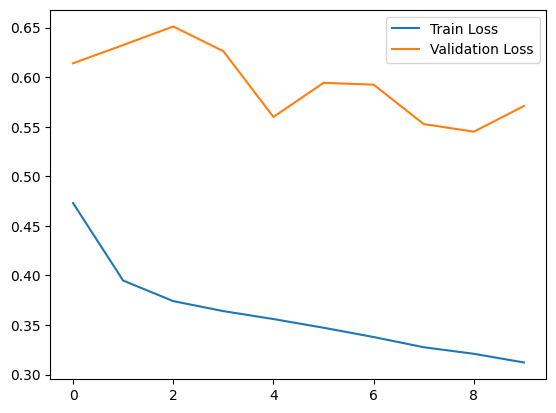

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [ ]:
print(model.input_shape)

(None, 7, 2)
